# Construct circuits

This page takes a closer look at Qiskit's [`QuantumCircuit`](/api/qiskit/qiskit.circuit.QuantumCircuit) class, including some more advanced methods you can use to create quantum circuits.

## What is a quantum circuit?

A simple quantum circuit is a collection of qubits and a list of instructions that act on those qubits. To demonstrate, the following cell creates a new circuit with two new qubits, then displays the circuit's [`qubits`](/api/qiskit/qiskit.circuit.QuantumCircuit#qubits) attribute.

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.qubits

[Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)]

Adding an instruction to the circuit appends the instruction to the circuit's [`data`](/api/qiskit/qiskit.circuit.QuantumCircuit#data) attribute. The following cell output shows `data` is a list of [`CircuitInstruction`](/api/qiskit/qiskit.circuit.CircuitInstruction) objects, each of which has an `operation` attribute, and a `qubits` attribute.

In [2]:
qc.x(0)  # Add X-gate to qubit 0
qc.data

[CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=())]

The easiest way to view this information is through the [`draw`](/api/qiskit/qiskit.circuit.QuantumCircuit#draw) method, which returns a visualization of a circuit. See [Visualize circuits](/build/circuit-visualization) for different ways of displaying quantum circuits.

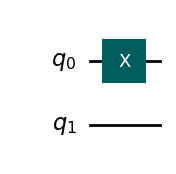

In [3]:
qc.draw("mpl")

Circuit instruction objects can contain "definition" circuits that describe the instruction in terms of more fundamental instructions. For example, the [X-gate](/api/qiskit/qiskit.circuit.library.XGate) is defined as a specific case of the [U3-gate](/api/qiskit/qiskit.circuit.library.U3Gate), a more general single-qubit gate.

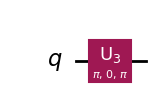

In [4]:
# Draw definition circuit of 0th instruction in `qc`
qc.data[0].operation.definition.draw("mpl")

Instructions and circuits are similar in that they both describe operations on bits and qubits, but they have different purposes:

- Instructions are treated as fixed, and their methods will usually return new instructions (without mutating the original object).
- Circuits are designed to be built over many lines of code, and [`QuantumCircuit`](/api/qiskit/qiskit.circuit.QuantumCircuit) methods often mutate the existing object.

The rest of this page illustrates how to manipulate quantum circuits.

## Build circuits

Methods such as [`QuantumCircuit.h`](/api/qiskit/qiskit.circuit.QuantumCircuit#h) and [`QuantumCircuit.cx`](/api/qiskit/qiskit.circuit.QuantumCircuit#cx) add specific instructions to circuits. To add instructions to a circuit more generally, use the [`append`](/api/qiskit/qiskit.circuit.QuantumCircuit#append) method. This takes an instruction and a list of qubits to apply the instruction to. See the [Circuit Library API documentation](/api/qiskit/circuit_library) for a list of supported instructions.

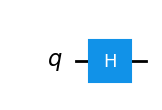

In [5]:
from qiskit.circuit.library import HGate

qc = QuantumCircuit(1)
qc.append(
    HGate(),  # New HGate instruction
    [0]       # Apply to qubit 0
)
qc.draw("mpl")

To combine two circuits, use the [`compose`](/api/qiskit/qiskit.circuit.QuantumCircuit#compose) method. This accepts another [`QuantumCircuit`](/api/qiskit/qiskit.circuit.QuantumCircuit) and an optional list of qubit mappings.

<Admonition type="note">
    The [`compose`](/api/qiskit/qiskit.circuit.QuantumCircuit#compose) method returns a new circuit and does **not** mutate either circuit it acts on. To mutate the circuit on which you're calling the [`compose`](/api/qiskit/qiskit.circuit.QuantumCircuit#compose) method, use the argument `inplace=True`.
</Admonition>

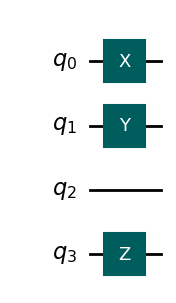

In [6]:
qc_a = QuantumCircuit(4)
qc_a.x(0)

qc_b = QuantumCircuit(2, name="qc_b")
qc_b.y(0)
qc_b.z(1)

# compose qubits (0, 1) of qc_a to qubits (1, 3) of qc_b respectively
combined = qc_a.compose(qc_b, qubits=[1, 3])
combined.draw("mpl")

You might also want to compile circuits into instructions to keep your circuits organized. You can convert a circuit to an instruction by using the [`to_instruction`](/api/qiskit/qiskit.circuit.QuantumCircuit#to_instruction) method, then append this to another circuit as you would any other instruction. The circuit drawn in the following cell is functionally equivalent to the circuit drawn in the previous cell.

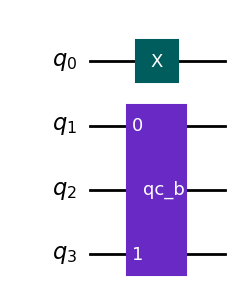

In [7]:
inst = qc_b.to_instruction()
qc_a.append(inst, [1, 3])
qc_a.draw("mpl")

If your circuit is unitary, you can convert it to a [`Gate`](/api/qiskit/qiskit.circuit.Gate)  by using the [`to_gate`](/api/qiskit/qiskit.circuit.QuantumCircuit#to_gate) method. [`Gate`](/api/qiskit/qiskit.circuit.Gate) objects are specific types of instructions that have some extra features, such as the [`control`](/api/qiskit/qiskit.circuit.Gate#control) method, which adds a quantum control.

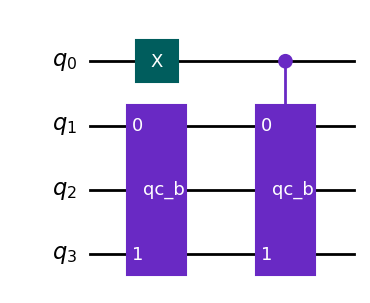

In [8]:
gate = qc_b.to_gate().control()
qc_a.append(gate, [0, 1, 3])
qc_a.draw("mpl")

To see what's going on, you can use the [`decompose`](/api/qiskit/qiskit.circuit.QuantumCircuit#decompose) method to expand each instruction into its definition.

<Admonition type="note">
    The [`decompose`](/api/qiskit/qiskit.circuit.QuantumCircuit#decompose) method returns a new circuit and does **not** mutate the circuit it acts on.
</Admonition>

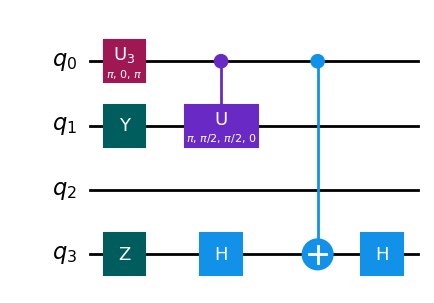

In [9]:
qc_a.decompose().draw("mpl")

## Parameterized circuits

Many near-term quantum algorithms involve executing many variations of a quantum circuit. Since constructing and optimizing large circuits can be computationally expensive, Qiskit supports **parameterized** circuits. These circuits have undefined parameters, and their values do not need to be defined until just before executing the circuit. This lets you move circuit construction and optimization out of the main program loop.  The following cell creates and displays a parameterized circuit.

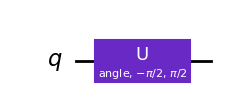

In [10]:
from qiskit.circuit import Parameter
angle = Parameter("angle")  # undefined number

# Create and optimize circuit once
qc = QuantumCircuit(1)
qc.rx(angle, 0)

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
qc = generate_preset_pass_manager(3, basis_gates=['u', 'cx']).run(qc)

qc.draw("mpl")

The following cell creates many variations of this circuit and displays one of the variations.

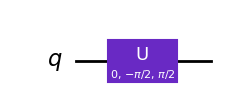

In [11]:
circuits = []
for value in range(100):
    circuits.append(
        qc.assign_parameters({ angle: value })
    )

circuits[0].draw("mpl")

You can find a list of a circuit's undefined parameters in its `parameters` attribute.

In [12]:
qc.parameters

ParameterView([Parameter(angle)])

To learn about near-term quantum algorithms, take our [Variational algorithm design](https://learning.quantum-computing.ibm.com/course/variational-algorithm-design) course.